In [1]:
!pip install tqdm

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Conv2DTranspose, BatchNormalization, Flatten, Reshape, LeakyReLU, Activation
from keras.activations import sigmoid
import tensorflow as tf

from utilities import show_graph

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data

Using TensorFlow backend.


In [3]:
mnist = input_data.read_data_sets('./data', one_hot=False)
image_size = (28, 28, 1)
def plot_sample(imgs):
    sample_imgs = imgs[:9]
    plt.figure(figsize=(12,12))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(sample_imgs[i].squeeze(), cmap='gray')

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


In [4]:
batch_size = 128
z_dim = 100
image_height = 28
image_width = 28
n_channels = 1

In [5]:
leaky_relu = lambda x: tf.maximum(x, 0.1 * x)

def upsample(x, depth, is_train, strides=2, activation=leaky_relu):
    x = tf.layers.conv2d_transpose(x, depth, 5, padding='same', strides=strides)
    x = tf.layers.batch_normalization(x, training=is_train)
    x = activation(x)
    return x, int(depth/2)

def generator(z, n_channels, is_train):
    with tf.variable_scope('generator', reuse=not is_train):
        depth = 64

#         print(z.get_shape().as_list())
        generator = tf.layers.dense(z, 7*7*depth)
        generator = tf.layers.batch_normalization(generator, training=is_train)
        generator = leaky_relu(generator)
#         print(generator.get_shape().as_list())

        generator = tf.reshape(generator, (-1, 7, 7, depth))
#         print(generator.get_shape().as_list())
        generator, depth = upsample(generator, depth, is_train, strides=2)
        generator, depth = upsample(generator, depth, is_train, strides=1)
        generator, depth = upsample(generator, depth, is_train, strides=1)
        generator, _ = upsample(generator, n_channels, is_train, strides=2, activation=tf.tanh)
#         print(generator.get_shape().as_list())
        
        return generator

In [6]:
def conv_layer(x, depth, is_train, is_bn=True, strides=2, activation=leaky_relu):
    x = tf.layers.conv2d(x, filters=depth, kernel_size=5, strides=strides, padding='same')
    if is_bn:
        x = tf.layers.batch_normalization(x, training=is_train)
    x = activation(x)
    return x, depth*2

def discriminator(images, is_train, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        depth = 32
        
#         print(images.get_shape().as_list())
        discriminator, depth = conv_layer(images, depth, is_train, is_bn=False)
#         print(discriminator.get_shape().as_list())
        discriminator, _ = conv_layer(discriminator, depth, is_train)
#         print(discriminator.get_shape().as_list())
        
        discriminator = tf.reshape(discriminator, (-1, 7*7*depth))
#         print(discriminator.get_shape().as_list())
        logits = tf.layers.dense(discriminator, 1)
#         print(logits.get_shape().as_list())
        
        return logits

Network:

In [7]:
def network(input_z, input_real, n_channels, is_train):
    d_labels = tf.stack([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))])
    learning_rate = 1e-3

    inputs_fake = generator(input_z, n_channels, is_train)
    d_logits_fake = discriminator(inputs_fake, is_train)
    d_logits_real = discriminator(input_real, is_train, reuse=True)

    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.stack([d_logits_fake, d_logits_real]), 
                                                                    labels=d_labels))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_logits_fake))) 
    
    return d_loss, g_loss

def optimization(d_loss, g_loss):
    learning_rate = 1e-3
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_trainer = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        g_trainer = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

    return d_trainer, g_trainer

In [8]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

# Tensor where we will feed the data into graph
z = tf.placeholder(tf.float32, (None, z_dim), 'z')
images = tf.placeholder(tf.float32, (None, image_width, image_height, n_channels), 'images')
# is_train = tf.placeholder(tf.bool, name='is_train')

d_loss, g_loss = network(z, images, 1, is_train=True)
d_trainer, g_trainer = optimization(d_loss, g_loss)

In [9]:
show_graph(tf.get_default_graph().as_graph_def())

In [10]:
def show_images(gen_im):
    plt.figure(figsize=(3,3))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(gen_im[i].squeeze())
    plt.show()

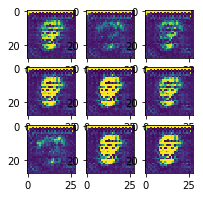

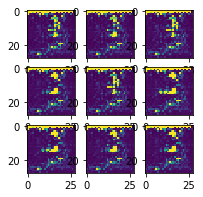

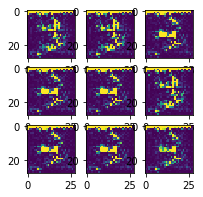

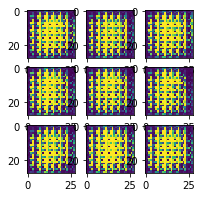

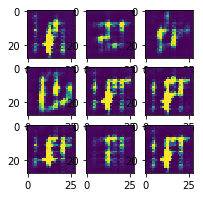

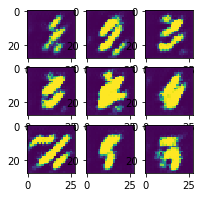

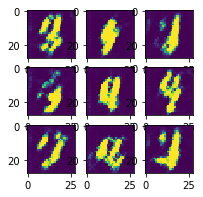

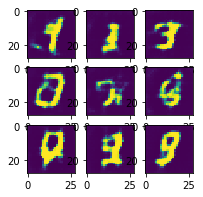

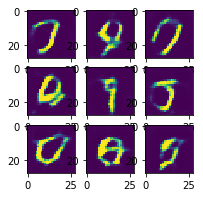

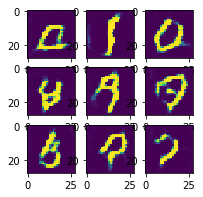

In [11]:
sess.run(tf.global_variables_initializer())
epochs = 10
batches_per_epoch = len(mnist.train.images) // batch_size

g_losses = []
d_losses = []

for epoch_i in range(epochs):
    for _ in range(batches_per_epoch):
        batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
        real_im = mnist.train.next_batch(batch_size)[0].reshape((-1,28,28, n_channels))
        
        d_l, _ = sess.run([d_loss, d_trainer], feed_dict={images: 2*(real_im-0.5), z: batch_z})
        g_l, _ = sess.run([g_loss, g_trainer], feed_dict={images: 2*(real_im-0.5), z: batch_z})
        
        g_losses.append(g_l)
        d_losses.append(d_l)
    batch_z = np.random.uniform(-1, 1, size=(9, z_dim))
    gen_im = sess.run(generator(z, n_channels, is_train=False), feed_dict={z: batch_z})
    show_images(gen_im)